In [101]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache using fc-list. This may take a moment.


In [78]:
item_cat = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
train = pd.read_csv("sales_train.csv")

## Explore each table

#### 1. Item categories
Looking at item categories. There are a total of 84 categories.

In [100]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [79]:
item_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [80]:
item_cat.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


Convrt cat id to uint8 to save space

In [81]:
item_cat['item_category_id'] = item_cat.item_category_id.astype("uint8")

#### Items information

In [82]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


There are 22170 different items

In [83]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [84]:
items['item_id'] = items.item_id.astype('uint16')
items['item_category_id'] = items.item_category_id.astype('uint8')

#### Shop information

In [85]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [86]:
shops['shop_id'] = shops.shop_id.astype('uint8')

#### Training dataset

Data is at daily level. Need to do some aggregations when modeling

In [87]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [89]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [90]:
train.duplicated().sum()

6

It seems that there are duplicates. Drop the duplicates

In [91]:
train = train.drop_duplicates()

#### It seems that most of the items are not sold that frequently as the 75 pct of item_cnt_day is 1. It is weird that there are negative item prices

In [92]:
train.describe().round(0)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935843.0,2935843.0,2935843.0,2935843.0,2935843.0
mean,15.0,33.0,10197.0,891.0,1.0
std,9.0,16.0,6324.0,1730.0,3.0
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


In [93]:
train['date_block_num'] = train.date_block_num.astype('uint8')
train['shop_id'] = train.shop_id.astype('uint8')
train['item_id'] = train.item_id.astype('uint16')
train['item_price'] = train.item_price.astype('int16')
train['item_cnt_day'] = train.item_cnt_day.astype('int16')

In [94]:
train['date'] = train['date'].str.replace('.','/')

In [95]:
train['date'] = pd.to_datetime(train.date,dayfirst=True, infer_datetime_format=True)

19 items with negative price

In [96]:
train.loc[train.item_price < 0,'item_id'].nunique()

19

In [97]:
train.loc[train.item_price < 0].head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2113,2013-01-30,0,24,5748,-32546,1
322740,2013-03-15,2,24,5748,-32546,1
484683,2013-05-15,4,32,2973,-1,1
679950,2013-07-05,6,22,5748,-32546,1
884848,2013-09-11,8,12,2410,-28546,1
885138,2013-09-17,8,12,11365,-6336,1
1006638,2013-10-24,9,12,7238,-23536,1
1058026,2013-11-19,10,12,5748,-29546,1
1163158,2013-12-13,11,12,6066,-19700,1
1394150,2014-02-10,13,12,5748,-28546,1


In [99]:
train.loc[(train.item_id == 2973) & (train.shop_id == 32)].tail(50)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,2013-01-29,0,32,2973,2499,1
67428,2013-01-25,0,32,2973,2499,1
67429,2013-01-22,0,32,2973,2499,1
67430,2013-01-21,0,32,2973,2499,1
67431,2013-01-18,0,32,2973,2499,1
67432,2013-01-17,0,32,2973,2499,1
67433,2013-01-15,0,32,2973,2499,3
187844,2013-02-05,1,32,2973,2499,1
187845,2013-02-14,1,32,2973,2499,1
484682,2013-05-23,4,32,2973,1249,1


#### Join all tables together

In [103]:
train_joined = pd.merge(train,items,on = 'item_id')
train_joined = pd.merge(train_joined,item_cat,on = 'item_category_id')

In [106]:
train_joined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999,1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-23,0,24,22154,999,1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2013-01-20,0,27,22154,999,1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,2013-01-02,0,25,22154,999,1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,2013-01-03,0,25,22154,999,1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


#### Aggregate to monthly level

Primary keys are date_block_num,shop_id,item_id

In [115]:
agg_dict = {'item_cnt_day':'sum',
            'item_price':'median'}

In [118]:
train_agg = train_joined.groupby(['date_block_num','shop_id','item_id',
                                  'item_name','item_category_id','item_category_name']).agg(agg_dict).reset_index()

In [119]:
train_agg.head()

,date_block_num,shop_id,item_id,item_name,item_category_id,item_category_name,item_cnt_day,item_price
0,0,0,32,1+1,40,Кино - DVD,6,221.0
1,0,0,33,1+1 (BD),37,Кино - Blu-Ray,3,347.0
2,0,0,35,10 ЛЕТ СПУСТЯ,40,Кино - DVD,1,247.0
3,0,0,43,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,1,221.0
4,0,0,51,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,2,128.5


In [122]:
train_agg.loc[train_agg.item_price < 0]

,date_block_num,shop_id,item_id,item_name,item_category_id,item_category_name,item_cnt_day,item_price
22457,0,24,5748,Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,-32546.0
142145,2,24,5748,Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,-32546.0
367119,6,22,5748,Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,-32546.0
473059,8,12,2410,CorelDRAW Graphics Suite X6 - Small Business E...,75,Программы - Для дома и офиса,1,-28546.0
525294,9,12,7238,UserGate Proxy & Firewall 6.X до 100 сессий,75,Программы - Для дома и офиса,1,-23536.0
575767,10,12,5748,Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,-29546.0
629348,11,12,6066,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,1,-19700.0
746723,13,12,5748,Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,-28546.0
804390,14,25,13199,Коллекционные шахматы (Властелин Колец),69,Подарки - Сувениры,1,-14537.0
844184,15,14,5748,Photoshop 13 Windows Russian BOX,75,Программы - Для дома и офиса,1,-28546.0


## Deeper analysis

#### Sales at different shops

In [125]:
sales_by_shop = train_agg.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()

In [126]:
sales_by_shop.head()

,date_block_num,shop_id,item_cnt_day
0,0,0,5578
1,0,1,2947
2,0,2,1146
3,0,3,767
4,0,4,2114


In [131]:
%matplotlib inline 

#### Since there are 60 shops, let's look at the top 10 shops with highest sales historically

In [149]:
top_10_shops = sales_by_shop.groupby(['shop_id'])['item_cnt_day'].sum(). \
reset_index(). \
sort_values(by = 'item_cnt_day',ascending = False)[:10]. \
shop_id

There seems to be a peak in sales during November. Might indicate that some event occurs during November

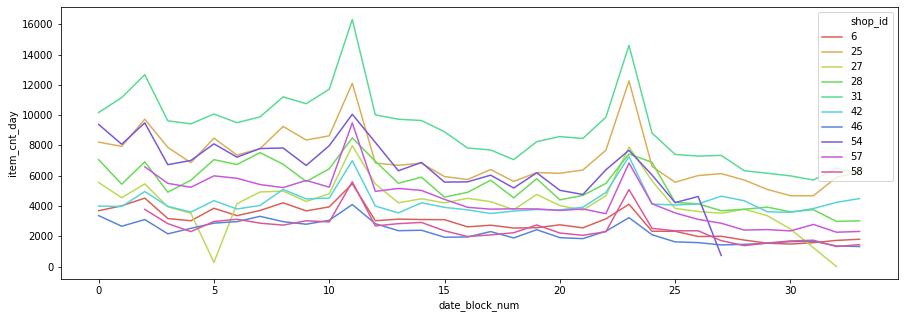

In [152]:
fig,ax = plt.subplots(figsize = [15,5])

sns.lineplot('date_block_num',
             'item_cnt_day',
             hue = 'shop_id',
             data = sales_by_shop[sales_by_shop.shop_id.isin(top_10_shops)],
             palette = sns.color_palette('hls',10))

In [189]:
train_agg.head()

,date_block_num,shop_id,item_id,item_name,item_category_id,item_category_name,item_cnt_day,item_price
0,0,0,32,1+1,40,Кино - DVD,6,221.0
1,0,0,33,1+1 (BD),37,Кино - Blu-Ray,3,347.0
2,0,0,35,10 ЛЕТ СПУСТЯ,40,Кино - DVD,1,247.0
3,0,0,43,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,1,221.0
4,0,0,51,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,2,128.5


In [190]:
sales_by_item = train_agg.groupby(['date_block_num','item_id']).agg({'item_cnt_day':'sum',
                                                                     'shop_id':'count'}).reset_index()

In [192]:
sales_by_item['item_cnt_per_shop'] = sales_by_item['item_cnt_day']/sales_by_item['shop_id']

In [205]:
sales_by_item.loc[sales_by_item.item_id == 19]

,date_block_num,item_id,item_cnt_day,shop_id,item_cnt_per_shop
0,0,19,1,1,1.0


In [182]:
# sales_by_item.loc[sales_by_item.item_cnt_day > 20] = 20

In [198]:
top_10_items = sales_by_item.groupby(['item_id'])['item_cnt_per_shop'].mean(). \
reset_index(). \
sort_values(by = 'item_cnt_per_shop',ascending = False)[:5]. \
item_id

#### Some interesting points

1. Games usually have a very high sales during launch but tend to approach zero as time passes (Diablo, GTA, Battlefield)
2. Item 20949 has been by far contributing most to sales

(0, 1000)

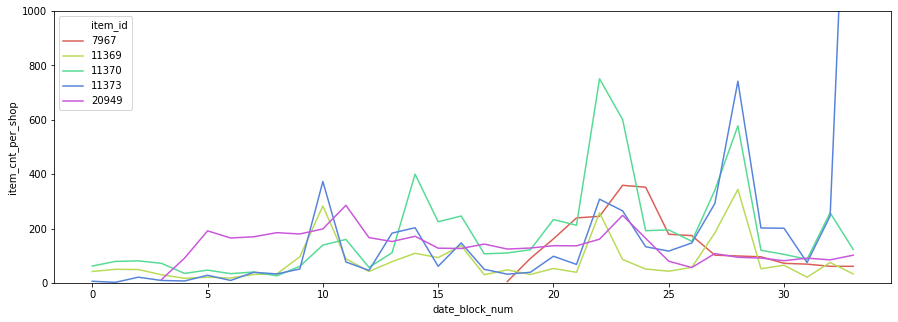

In [200]:
fig,ax = plt.subplots(figsize = [15,5])

sns.lineplot('date_block_num',
             'item_cnt_per_shop',
             hue = 'item_id',
             data = sales_by_item[sales_by_item.item_id.isin(top_10_items)],
             palette = sns.color_palette('hls',5),
             ax = ax)

ax.set_ylim([0,1000])

In [204]:
train_agg.loc[train_agg.item_id == 11369].head()

,date_block_num,shop_id,item_id,item_name,item_category_id,item_category_name,item_cnt_day,item_price
11276,0,12,11369,Доставка (Почта),9,Доставка товара,42,523.5
74812,1,12,11369,Доставка (Почта),9,Доставка товара,50,563.0
130620,2,12,11369,Доставка (Почта),9,Доставка товара,49,580.0
192357,3,12,11369,Доставка (Почта),9,Доставка товара,30,460.0
247354,4,12,11369,Доставка (Почта),9,Доставка товара,17,493.0


Since there are many categories, it might make sense to analyze the sales of each category to find out if there are any categories that are important